# **GEMMA 3NCORE** | Impact on Healthcare application and beyond.

----
## **OVERVIEW**
----


**GEMMA 3NCORE** (ENCORE, with "3n" as a tribute to Gemma 3n) [1] is a proof-of-concept protoype by Shehab Anwer for The Adimension [2]. It demonstrates **intra-Gemmaverse knowledge transfer** through **cross-architecture knowledge distillation (KD)**, shifting medical imaging knowledge from **MedGemma's [3] MedSigLIP vision encoder** to **Gemma 3n's TIMM vision backbone** [4]. This leverages Gemma 3n's multimodality, especially its **Matryoshka-model nested transformer** for elastic efficient submodel extraction [5] to support scalable, resources- and device-optimised healthcare applications, like in cardiac imaging analysis as in this pilot.

**3NCORE KD pipeline** targets regression tasks for cardiac metrics—End-Diastolic Volume (EDV), End-Systolic Volume (ESV), and Ejection Fraction (EF)—using datasets like EchoNet-Dynamic [6] and CAMUS [7]. Key techniques:
- **Mean Squared Error (MSE)** loss for task-specific predictions.
- Feature matching loss for alignment, with projectors to match layer dimensions and adaptive pooling for memory efficiency.
- **Parameter-Efficient Fine-Tuning (PEFT) through Low-Rank Adaptation (LoRA)** [8] or **Quantised LoRA (QLoRA)** [9] for scalability and resource adaptation.
- Gradient accumulation and curriculum learning through gradual adjustment of feature loss weight for low-resource setups, like ephemral environments (Google Colab / Kaggle notebooks).

As part of the **ATRIOM (Artifact Transformation & Resources Interoperability in Machine Learning) collection**—inspired by atrial functions (Atrium) for interoperability (IO)—ATRIOM has three phases:
- **Reservoir**: Gather artifacts and set up environments, with fresh package installs and automated reporting (JSON/DataFrame) for libraries like PyTorch [10] and Hugging Face Transformers [11].
- **Conduit**: Build data pipelines and bridges, including on-the-fly video frame extraction (e.g., ES/ED frames from EchoNet videos) to save memory, auto GPU/CPU detection with 8-bit quantization [9], and IPython widgets for hyperparameter tuning.
- **Active**: Train, analyze, and generate adapters. The custom student model fuses ES/ED vision features via a sequential layer before regression heads; it supports timestamped checkpointing of LoRA adapters and full models for versioning.

Focused on healthcare, the methodology aligns ethically with **Health AI Developer Foundations** [12] and the **DEITY Principles Framework** [2],  foundational to the Adimension solutions: **D**ata for transparent, diverse inputs; **E**thics for governance; **I**nformatics for interpretable outputs; **T**echnology for adaptive, empowering **Y**ou, both the human & machine, through solutions that bridges human ingenuity with machine intelligence. Altogether, aiming at an impact on **Healthcare and beyond**, through scalable, equitable AI that tackles interoperability and resource constraints [2], as well as a deeper Gemmaverse insights [1,3], boosting computational efficiency to sparks cross-modal innovations [12].

---

**Disclaimer**: For research only; not for clinical use. Follow providers' ethical terms for models/datasets [1-12].

---

### **References**
1. Gemma Team. (2025). Gemma 3n. Google DeepMind. https://ai.google.dev/gemma/docs/gemma-3n.
2. Anwer, S. (2025). The Adimension: Bridging interoperability through DEITY Principles. *European Heart Journal - Imaging Methods and Practice*. https://doi.org/10.1093/ehjimp/qyaf038.
3. Sellergren, A., et al. (2025). MedGemma Technical Report. arXiv:2507.05201.
4. Wightman, R. (2019). PyTorch Image Models. https://github.com/huggingface/pytorch-image-models.
5. Devvrit et al. (2023). MatFormer: Nested Transformer for Elastic Inference. arXiv:2310.07707.
6. Ouyang, D., et al. (2020). Video-based AI for beat-to-beat assessment of cardiac function. *Nature*. https://doi.org/10.1038/s41586-020-2145-8 (EchoNet-Dynamic Dataset).
7. Leclerc, S., et al. (2019). Deep Learning for Segmentation using an Open Large-Scale Dataset in 2D Echocardiography. *IEEE Transactions on Medical Imaging*. https://doi.org/10.1109/TMI.2019.2900516 (CAMUS Dataset).
8. Hu, E. J., et al. (2021). LoRA: Low-Rank Adaptation of Large Language Models. arXiv:2106.09685.
9. Dettmers, T., et al. (2022). LLM.int8(): 8-bit Matrix Multiplication for Transformers at Scale. arXiv:2208.07339.
10. Paszke, A., et al. (2019). PyTorch: An Imperative Style, High-Performance Deep Learning Library. *NeurIPS*.
11. Wolf, T., et al. (2019). Hugging Face's Transformers. arXiv:1910.03771.
12. Google Health AI Team. (2024). Health AI Developer Foundations. arXiv:2411.15128.

------

## **KNOWLEDGE DISTILATION NOTEBOOK**

------

In [ ]:
# @title **I. ATRIOM RESERVOIR PHASE**: 1) Environment Setup
# Uninstall the packages for a clean slate (ignoring errors if not installed)
%pip uninstall -y torch torchvision numpy pandas opencv-python Pillow transformers accelerate peft bitsandbytes huggingface-hub timm tqdm matplotlib seaborn scikit-learn || true

# Install/upgrade the packages fresh without caching
%pip install --no-cache-dir torch torchvision 'numpy<2' pandas opencv-python Pillow transformers accelerate peft bitsandbytes huggingface-hub timm git+https://github.com/huggingface/pytorch-image-models.git tqdm matplotlib seaborn scikit-learn || true

Found existing installation: torch 2.8.0
Uninstalling torch-2.8.0:
  Successfully uninstalled torch-2.8.0
Found existing installation: torchvision 0.23.0
Uninstalling torchvision-0.23.0:
  Successfully uninstalled torchvision-0.23.0
Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: pandas 2.3.1
Uninstalling pandas-2.3.1:
  Successfully uninstalled pandas-2.3.1
Found existing installation: opencv-python 4.11.0.86
Uninstalling opencv-python-4.11.0.86:
  Successfully uninstalled opencv-python-4.11.0.86
Found existing installation: pillow 11.3.0
Uninstalling pillow-11.3.0:
  Successfully uninstalled pillow-11.3.0
Found existing installation: transformers 4.55.0
Uninstalling transformers-4.55.0:
  Successfully uninstalled transformers-4.55.0
Found existing installation: accelerate 1.10.0
Uninstalling accelerate-1.10.0:
  Successfully uninstalled accelerate-1.10.0
Found existing installation: peft 0.17.0


In [ ]:
# @title **I. ATRIOM RESERVOIR PHASE**: 2) Confirmation of Environment Setup
#Environment report
import subprocess
import json
from datetime import datetime
import os
import pandas as pd
from IPython.display import display

# Get current timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Ensure the directory exists
os.makedirs('/content/drive/MyDrive/Gemma_3nCORE/environment/', exist_ok=True)

# File path for JSON
file_path = f"/content/drive/MyDrive/Gemma_3nCORE/environment/env_{timestamp}.json"

# Run pip list to get all installed packages in JSON format
result = subprocess.run(['pip', 'list', '--format=json'], capture_output=True, text=True)
data = json.loads(result.stdout)

# Save the full exhaustive report as JSON
with open(file_path, 'w') as f:
    json.dump(data, f, indent=4)

print(f"Full environment report saved to: {file_path}")

# Packages of interest for the table
packages_of_interest = [
    'torch', 'torchvision', 'numpy', 'pandas', 'opencv-python', 'Pillow',
    'transformers', 'accelerate', 'peft', 'bitsandbytes', 'huggingface-hub',
    'timm', 'tqdm', 'matplotlib', 'seaborn', 'scikit-learn'
]

# Create DataFrame from the data
df = pd.DataFrame(data)

# Filter to packages of interest and sort by name
filtered_df = df[df['name'].isin(packages_of_interest)].sort_values('name')

# Display the presentable table
print("\nInstalled versions of the specified packages:")
display(filtered_df)

Full environment report saved to: /content/drive/MyDrive/Gemma_3nCORE/environment/env_20250812_110244.json

Installed versions of the specified packages:


,name,version
1,accelerate,1.10.0
33,bitsandbytes,0.47.0
206,huggingface-hub,0.34.4
302,matplotlib,3.10.5
341,numpy,1.26.4
365,opencv-python,4.11.0.86
375,pandas,2.3.1
387,peft,0.17.0
490,scikit-learn,1.7.1
494,seaborn,0.13.2


In [ ]:
# @title **II. ATRIOM CONDUIT PHASE**: 1) Setting up access to the models, the storage, and the dataset
from google.colab import drive, userdata
from huggingface_hub import login

# Google Drive Access
drive.mount('/content/drive')

# Hugging Face Access
try:
    hf_token = userdata.get('HF_TOKEN')
    login(token=hf_token)
    print("✅ Successfully logged in to Hugging Face.")
except Exception as e:
    print(f"❌ Could not log in. Please ensure you have added your Hugging Face token to Colab Secrets with the name 'HF_TOKEN'.")

# Import Libraries
import pandas as pd
import numpy as np
import os
import cv2
import torch
from tqdm.notebook import tqdm
from transformers import AutoModelForImageTextToText, Gemma3nForConditionalGeneration, AutoProcessor, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import gc
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.manifold import TSNE

# Primary data storage location setup
GDRIVE_PROJECT_PATH = "/content/drive/MyDrive/GEMMA-3NCORE"
DATA_DIR = os.path.join(GDRIVE_PROJECT_PATH, "EchoNet-Dynamic")
VIDEO_DIR = os.path.join(DATA_DIR, "Videos")
OUTPUT_DIR = os.path.join(GDRIVE_PROJECT_PATH, "output")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load Models from local storage
## from Google Drive
# STUDENT_MODEL_PATH = "/content/drive/MyDrive/Gemma_3nCORE/models/Gemma3n"
# TEACHER_MODEL_PATH = "/content/drive/MyDrive/Gemma_3nCORE/models/MedGemma"

## Load models from Hugging Face
STUDENT_MODEL_PATH = "google/gemma-3n-E2B-it"
TEACHER_MODEL_PATH = "google/medgemma-4b-pt"


# Models Implementation Strategy
## Model Training or Pretrained Adapters switch
TRAIN = True  # False = load pre-trained adapters
## Gemma 3n MatFormer submodel loader
USE_MATFORMER_SUBMODEL = True

# Torch Device: Primary Cuda settng, otherwise shifts to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("⚠️ IMPORTANT: ALL ARTIFACTS (MODELS & DATASET) ARE ACCESSIBLE THROUGH THEIR PROVIDERS. PLEASE ACQUIRE THE NECESSARY PERMISSIONS")
print(f"✅ Device: {device}")
print(f"✅ Student {STUDENT_MODEL_PATH}")
print(f"✅ Teacher {TEACHER_MODEL_PATH}")

# EchoNet Dynamic Dataset preprocessing
FILE_LIST_PATH = os.path.join(DATA_DIR, "FileList.csv")
TRACINGS_PATH = os.path.join(DATA_DIR, "VolumeTracings.csv")
OUTPUT_PATH = os.path.join(OUTPUT_DIR, "annot_targets_pilot.csv")

regenerate = True  # Force meta-data file regeneration - after verification of content

if os.path.exists(OUTPUT_PATH):
    df = pd.read_csv(OUTPUT_PATH)
    if 'EDV' in df.columns and 'ESV' in df.columns:
        regenerate = False
        print(f"✅ Metadata preprocessing available: CSV includes target frames and volume measurements at '{OUTPUT_PATH}'.")
    else:
        print("➡️ Metadata reuires preprocessing and consolidation into a CSV with target frames, volumes measurements, and videofile name - Regeneration starts ...")

if regenerate:
    print("➡️ Metadata preprocessing starts...")
    try:
        tracings_df = pd.read_csv(TRACINGS_PATH)
        file_list_df = pd.read_csv(FILE_LIST_PATH)

        print(f"Initial file list size: {len(file_list_df)}")
        # Check/Filter any invalid/incomplete metadata to avoid training failure
        file_list_df = file_list_df.dropna(subset=['FPS', 'NumberOfFrames'])
        file_list_df = file_list_df[file_list_df['FPS'] > 0]
        file_list_df = file_list_df[file_list_df['NumberOfFrames'] > 0]
        print(f"Valid metadata rows count: {len(file_list_df)}")

        #
        tracings_df['CleanFileName'] = tracings_df['FileName'].str.replace('.avi', '')
        file_list_df['CleanFileName'] = file_list_df['FileName'].str.replace('.avi', '')

        # Aggregate Frame Numbers
        aggregated = tracings_df.groupby('CleanFileName')['Frame'].unique().apply(sorted).reset_index()
        aggregated['ES_Frame'] = aggregated['Frame'].apply(lambda x: x[0] if len(x)==2 else None)
        aggregated['ED_Frame'] = aggregated['Frame'].apply(lambda x: x[1] if len(x)==2 else None)
        aggregated = aggregated.dropna(subset=['ES_Frame', 'ED_Frame'])

        # Merge DataFrames
        minimized_df = pd.merge(aggregated, file_list_df, on='CleanFileName', how='inner')

        # Generate the metadata CSV
        minimized_df = minimized_df[['FileName', 'ESV', 'EDV', 'EF', 'ES_Frame', 'ED_Frame', 'NumberOfFrames']]
        minimized_df['FileName'] = minimized_df['FileName'].apply(lambda x: x if x.endswith('.avi') else x + '.avi')
        minimized_df.to_csv(OUTPUT_PATH, index=False)
        print(f"\n✅ Successfully created '{OUTPUT_PATH}' with temporal features and correct ED/ES assignment.")
    except FileNotFoundError as e:
        print(f"❌ Error during preprocessing: {e}")

print("---" * 20)
print("✅ DATA PREPARATION COMPLETE")
print(f"   -> Main data file is ready at: {OUTPUT_PATH}")
if 'minimized_df' in locals():
    print(f"   -> Total aligned videos found: {len(minimized_df)}")
else:
    print("   -> Loaded existing data file.")
print("⚠️ IMPORTANT: ALL ARTIFACTS (MODELS & DATASET) ARE ACCESSIBLE THROUGH THEIR PROVIDERS. PLEASE ACQUIRE THE NECESSARY PERMISSIONS")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Successfully logged in to Hugging Face.
⚠️ IMPORTANT: ALL ARTIFACTS (MODELS & DATASET) ARE ACCESSIBLE THROUGH THEIR PROVIDERS. PLEASE ACQUIRE THE NECESSARY PERMISSIONS
✅ Device: cuda
✅ Student google/gemma-3n-E2B-it
✅ Teacher google/medgemma-4b-pt
✅ Metadata preprocessing available: CSV includes target frames and volume measurements at '/content/drive/MyDrive/GEMMA-3NCORE/output/annot_targets_pilot.csv'.
------------------------------------------------------------
✅ DATA PREPARATION COMPLETE
   -> Main data file is ready at: /content/drive/MyDrive/GEMMA-3NCORE/output/annot_targets_pilot.csv
   -> Loaded existing data file.
⚠️ IMPORTANT: ALL ARTIFACTS (MODELS & DATASET) ARE ACCESSIBLE THROUGH THEIR PROVIDERS. PLEASE ACQUIRE THE NECESSARY PERMISSIONS


In [ ]:
# @title **II. ATRIOM CONDUIT PHASE**: 2) Loading the models and Configuration Controls of Knowledge Distillation
import ipywidgets as widgets
from IPython.display import display
import torch
import torch.nn as nn
from transformers import AutoModelForImageTextToText, Gemma3nForConditionalGeneration, AutoProcessor, BitsAndBytesConfig
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import cv2
import os

# On-fly frame extraction
def get_frames_from_video(video_path, frame_indices):
    cap = cv2.VideoCapture(video_path)
    frames = []
    for frame_idx in sorted(frame_indices):
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            img = Image.fromarray(frame).convert('RGB')  # Ensure RGB mode
            frames.append(img)
    cap.release()
    return frames

# Define the EchoDataset structure
class EchoDataset(Dataset):
    def __init__(self, df, video_dir):
        self.df = df
        self.video_dir = video_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        video_path = os.path.join(self.video_dir, row['FileName'])

        # Get only the ES and ED frames as specified in the CSV
        frames = get_frames_from_video(video_path, [row['ES_Frame'], row['ED_Frame']])
        if len(frames) < 2:
            return None

        # Return only the images and the three target values
        return {
            "images": frames,
            "ef": torch.tensor(row['EF'], dtype=torch.float32),
            "edv": torch.tensor(row['EDV'], dtype=torch.float32),
            "esv": torch.tensor(row['ESV'], dtype=torch.float32),
        }

# Samples collation from EchoDataset into model-ready batches
def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    if not batch:
        return None

    images = [item['images'] for item in batch]
    ef = torch.stack([item['ef'] for item in batch])
    edv = torch.stack([item['edv'] for item in batch])
    esv = torch.stack([item['esv'] for item in batch])

    # Return a dictionary
    return {"images": images, "ef": ef, "edv": edv, "esv": esv}

def get_nested_attr(obj, attr_str):
    attrs = attr_str.split('.')
    for attr in attrs:
        obj = getattr(obj, attr)
    return obj

# Memory-effient Feature Extractor
class FeatureExtractor(nn.Module):
    def __init__(self, model, layers_to_extract):
        super().__init__()
        self.model = model
        self.layers_to_extract = layers_to_extract
        self._features = {}
        self.hooks = []

        for layer_id in layers_to_extract:
            layer_id_clean = layer_id.replace('.', '_')
            try:
                layer = get_nested_attr(self.model, layer_id)
                hook = layer.register_forward_hook(self.save_outputs_hook(layer_id_clean))
                self.hooks.append(hook)
            except AttributeError:
                print(f"⚠️ Warning: Layer '{layer_id}' not found in model.")

    def save_outputs_hook(self, layer_id):
        def fn(_, __, output):
            feat = output[0] if isinstance(output, tuple) else output
            self._features[layer_id] = feat.detach()
        return fn

    def forward(self, x):
        self._features.clear()
        # Note: This forward is specific to the teacher model's structure
        with torch.no_grad():
            _ = self.model.vision_tower(x)
        return self._features

    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()

# Architecture Definitions
class TargetStudentModel(nn.Module):
    def __init__(self, model_path, **kwargs):
        super().__init__()
        self.gemma = Gemma3nForConditionalGeneration.from_pretrained(model_path, **kwargs)
        vision_hidden_size = self.gemma.config.vision_config.hidden_size

        # Define model_dtype from the loaded model before using it
        model_dtype = self.gemma.dtype

        # Define the custom layers
        self.feature_fusion = nn.Sequential(
            nn.Linear(vision_hidden_size * 2, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Tanh()
        )
        self.ef_head = nn.Linear(256, 1)
        self.edv_head = nn.Linear(256, 1)
        self.esv_head = nn.Linear(256, 1)

        # Cast custom layers to the correct dtype to match models I/O processes
        self.feature_fusion.to(model_dtype)
        self.ef_head.to(model_dtype)
        self.edv_head.to(model_dtype)
        self.esv_head.to(model_dtype)

    def forward(self, pixel_values):
        # Process frames using the model's built-in high-level function.
        # Use `.model` to access the base model inside the PEFT wrapper.
        all_feats = self.gemma.model.get_image_features(pixel_values)  # Direct tensor output

        # Global average pooling over the token dimension
        all_feats = all_feats.mean(dim=1)

        # Separate the ES and ED frame features
        es_feats, ed_feats = all_feats.chunk(2, dim=0)

        # Fuse the two vision features and predict
        combined_vision = torch.cat([es_feats, ed_feats], dim=-1)
        refined_features = self.feature_fusion(combined_vision)

        ef_pred = torch.sigmoid(self.ef_head(refined_features)).squeeze(-1) * 100
        edv_pred = self.edv_head(refined_features).squeeze(-1)
        esv_pred = self.esv_head(refined_features).squeeze(-1)

        return ef_pred, edv_pred, esv_pred

# GPU / CPU Configurations for Checkpoint loading on Google Colab
print("➡️ Configuring for Google Colab...")

if torch.cuda.is_available():
    print("✅ GPU detected: Mixed Precision and Gradient Checkpoint loading.")
    bnb_config = BitsAndBytesConfig(
        load_in_8bit=True,
        bnb_8bit_compute_dtype=torch.bfloat16
    )
    student_kwargs = {
        "quantization_config": bnb_config,
        "torch_dtype": torch.bfloat16,
        "device_map": "auto",
        "low_cpu_mem_usage": True
    }
    teacher_kwargs = {
        "torch_dtype": torch.bfloat16,
        "device_map": "auto",
        "low_cpu_mem_usage": True
    }
else:
    print("⚠️ No GPU detected. CPU can be slower.")
    student_kwargs = {"torch_dtype": torch.float32, "low_cpu_mem_usage": True}
    teacher_kwargs = {"torch_dtype": torch.float32, "low_cpu_mem_usage": True}

# Checkpoints loading
try:
    print("➡️ Memory-optimised checkpoints loading ...")
    student_model = TargetStudentModel(STUDENT_MODEL_PATH, **student_kwargs)
    student_model.to(device)
    if hasattr(student_model.gemma, 'gradient_checkpointing_enable'):
        student_model.gemma.gradient_checkpointing_enable()

    teacher_model = AutoModelForImageTextToText.from_pretrained(TEACHER_MODEL_PATH, **teacher_kwargs)
    teacher_model.eval()
    for param in teacher_model.parameters():
        param.requires_grad = False
    print("\n✅ TEACHER and STUDENT models are ready.")
except Exception as e:
    print(f"❌ Error during model loading: {e}")

# Load processors
teacher_processor = AutoProcessor.from_pretrained(TEACHER_MODEL_PATH, use_fast=True)
student_processor = AutoProcessor.from_pretrained(STUDENT_MODEL_PATH, use_fast=True)

# Interactive Control Panel
print("\n--- ⚙️ Hyperparameter & Data Control Panel ---")
sample_size_slider = widgets.IntSlider(
    value=100, min=1, max=11000, step=50, description='Pilot Sample Size:'
)
lr_slider = widgets.FloatLogSlider(
    value=2e-5, min=-6, max=-2, step=0.1, description='Learning Rate:', readout_format='.2e'
)
epochs_slider = widgets.IntSlider(
    value=3, min=1, max=100, step=1, description='Epochs:'
)
feature_weight_slider = widgets.FloatSlider(
    value=0.05, min=0.01, max=1.0, step=0.01, description='Feature Loss Wt:', readout_format='.2f'
)
lora_r_slider = widgets.IntSlider(
    value=8, min=4, max=64, step=4, description='LoRA Rank (r):'
)
lora_alpha_slider = widgets.IntSlider(
    value=16, min=4, max=64, step=4, description='LoRA Alpha:'
)
display(sample_size_slider, lr_slider, epochs_slider, feature_weight_slider, lora_r_slider, lora_alpha_slider)

# --- Summary Report ---
print("---" * 20)
print("✅ MODELS LOADED - Please the training process parameters using the sliders above")

➡️ Configuring for Google Colab...
✅ GPU detected: Mixed Precision and Gradient Checkpoint loading.
➡️ Memory-optimised checkpoints loading ...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]


✅ TEACHER and STUDENT models are ready.

--- ⚙️ Hyperparameter & Data Control Panel ---


IntSlider(value=100, description='Pilot Sample Size:', max=11000, min=1, step=50)

FloatLogSlider(value=2e-05, description='Learning Rate:', max=-2.0, min=-6.0, readout_format='.2e')

IntSlider(value=3, description='Epochs:', min=1)

FloatSlider(value=0.05, description='Feature Loss Wt:', max=1.0, min=0.01, step=0.01)

IntSlider(value=8, description='LoRA Rank (r):', max=64, min=4, step=4)

IntSlider(value=16, description='LoRA Alpha:', max=64, min=4, step=4)

------------------------------------------------------------
✅ MODELS LOADED - Please the training process parameters using the sliders above


Training Settings:
  Pilot Sample Size: 501
  Learning Rate: 2.00e-05
  Epochs: 5
  Feature Loss Weight: 0.15
  LoRA Rank (r): 8
  LoRA Alpha: 8
  Output Directory: /content/drive/MyDrive/GEMMA-3NCORE/output/run_20250812_114216
➡️ Applying LoRA config from sliders...
trainable params: 4,079,616 || all params: 5,443,517,888 || trainable%: 0.0749
ℹ️ Deeper hook addition logic commented out to conserve memory.
✅ Feature extractors ready with adaptive pooling for efficiency.
Using sample size: 501
✅ Training setup complete. Train samples: 426, Val samples: 75
   Batch size: 16
   Device: cuda
Epoch 1: Task weight=0.85, Feature weight=0.15


Epoch 1/5:   0%|          | 0/27 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:186: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Validation:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:186: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")



Epoch 1:
  Train Loss: 11653.3995
  Val Loss: 15170.0063
  ✅ New best! Saving adapters to '/content/drive/MyDrive/GEMMA-3NCORE/output/run_20250812_114216/best_model_adapters'
  ✅ New best! Full model (including heads) saved to '/content/drive/MyDrive/GEMMA-3NCORE/output/run_20250812_114216/best_model_full.pth'
  ✅ Adapter checkpoint saved to '/content/drive/MyDrive/GEMMA-3NCORE/output/run_20250812_114216/checkpoint_epoch_1'
  ✅ Full checkpoint (including heads) saved to '/content/drive/MyDrive/GEMMA-3NCORE/output/run_20250812_114216/checkpoint_epoch_1_full.pth'
Epoch 2: Task weight=0.81, Feature weight=0.19


Epoch 2/5:   0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 2:
  Train Loss: 11212.8659
  Val Loss: 15111.3354
  ✅ New best! Saving adapters to '/content/drive/MyDrive/GEMMA-3NCORE/output/run_20250812_114216/best_model_adapters'
  ✅ New best! Full model (including heads) saved to '/content/drive/MyDrive/GEMMA-3NCORE/output/run_20250812_114216/best_model_full.pth'
  ✅ Adapter checkpoint saved to '/content/drive/MyDrive/GEMMA-3NCORE/output/run_20250812_114216/checkpoint_epoch_2'
  ✅ Full checkpoint (including heads) saved to '/content/drive/MyDrive/GEMMA-3NCORE/output/run_20250812_114216/checkpoint_epoch_2_full.pth'
Epoch 3: Task weight=0.78, Feature weight=0.22


Epoch 3/5:   0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 3:
  Train Loss: 10861.1400
  Val Loss: 15045.0842
  ✅ New best! Saving adapters to '/content/drive/MyDrive/GEMMA-3NCORE/output/run_20250812_114216/best_model_adapters'
  ✅ New best! Full model (including heads) saved to '/content/drive/MyDrive/GEMMA-3NCORE/output/run_20250812_114216/best_model_full.pth'
  ✅ Adapter checkpoint saved to '/content/drive/MyDrive/GEMMA-3NCORE/output/run_20250812_114216/checkpoint_epoch_3'
  ✅ Full checkpoint (including heads) saved to '/content/drive/MyDrive/GEMMA-3NCORE/output/run_20250812_114216/checkpoint_epoch_3_full.pth'
Epoch 4: Task weight=0.74, Feature weight=0.26


Epoch 4/5:   0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 4:
  Train Loss: 10488.1657
  Val Loss: 14990.6232
  ✅ New best! Saving adapters to '/content/drive/MyDrive/GEMMA-3NCORE/output/run_20250812_114216/best_model_adapters'
  ✅ New best! Full model (including heads) saved to '/content/drive/MyDrive/GEMMA-3NCORE/output/run_20250812_114216/best_model_full.pth'
  ✅ Adapter checkpoint saved to '/content/drive/MyDrive/GEMMA-3NCORE/output/run_20250812_114216/checkpoint_epoch_4'
  ✅ Full checkpoint (including heads) saved to '/content/drive/MyDrive/GEMMA-3NCORE/output/run_20250812_114216/checkpoint_epoch_4_full.pth'
Epoch 5: Task weight=0.70, Feature weight=0.30


Epoch 5/5:   0%|          | 0/27 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 5:
  Train Loss: 10067.9591
  Val Loss: 14948.4533
  ✅ New best! Saving adapters to '/content/drive/MyDrive/GEMMA-3NCORE/output/run_20250812_114216/best_model_adapters'
  ✅ New best! Full model (including heads) saved to '/content/drive/MyDrive/GEMMA-3NCORE/output/run_20250812_114216/best_model_full.pth'
  ✅ Adapter checkpoint saved to '/content/drive/MyDrive/GEMMA-3NCORE/output/run_20250812_114216/checkpoint_epoch_5'
  ✅ Full checkpoint (including heads) saved to '/content/drive/MyDrive/GEMMA-3NCORE/output/run_20250812_114216/checkpoint_epoch_5_full.pth'

✅ Training complete!
Best validation loss: 14948.4533


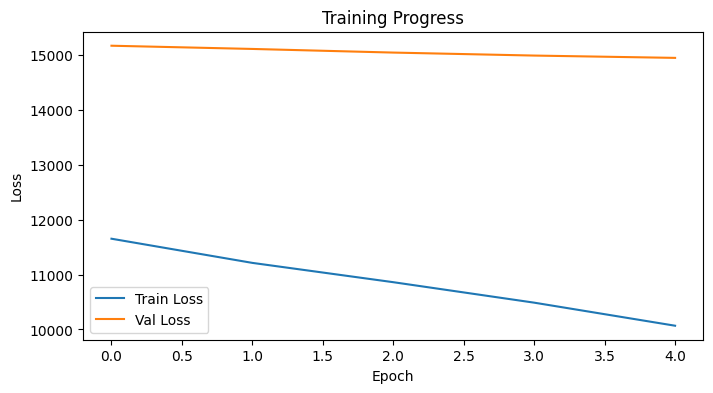

------------------------------------------------------------
✅ CELL 3 COMPLETE: TRAINING FINISHED
   -> Best model adapters saved to: /content/drive/MyDrive/GEMMA-3NCORE/output/run_20250812_114216/best_model_adapters
   -> Best full model (including heads) saved to: /content/drive/MyDrive/GEMMA-3NCORE/output/run_20250812_114216/best_model_full.pth
   -> Best Validation Loss: 14948.4533
   -> Training history logged in: /content/drive/MyDrive/GEMMA-3NCORE/output/run_20250812_114216/training_log.json


In [ ]:
# @title **III. ATRIOM ACTIVE PHASE**: KNOWLEDGE DISTILLATION
import json
import copy
from torch.amp import GradScaler, autocast
import gc
import torch.nn.functional as F  # For adaptive pooling
from datetime import datetime
import psutil
import os

# Create timestamped output folder
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
run_dir = os.path.join(OUTPUT_DIR, f"run_{timestamp}")
os.makedirs(run_dir, exist_ok=True)

# Report settings from sliders
print("Training Settings:")
print(f"  Pilot Sample Size: {sample_size_slider.value}")
print(f"  Learning Rate: {lr_slider.value:.2e}")
print(f"  Epochs: {epochs_slider.value}")
print(f"  Feature Loss Weight: {feature_weight_slider.value:.2f}")
print(f"  LoRA Rank (r): {lora_r_slider.value}")
print(f"  LoRA Alpha: {lora_alpha_slider.value}")
print(f"  Output Directory: {run_dir}")

# Use the pre-loaded student_model from Cell 2 directly for training (no redundant copy)
student_model_fresh = student_model  # Reference the existing instance
student_model_fresh.to(device)

# LoRA Sliders values applied to the traininig student model
print("➡️ Applying LoRA config from sliders...")
lora_config = LoraConfig(
    r=lora_r_slider.value,
    lora_alpha=lora_alpha_slider.value,
    target_modules=['q_proj', 'v_proj', 'k_proj', 'o_proj'],
    lora_dropout=0.1,
    bias="none"
)
student_model_peft = get_peft_model(student_model_fresh.gemma, lora_config)
student_model_fresh.gemma = student_model_peft  # Re-assign the PEFT-wrapped model
student_model_fresh.gemma.print_trainable_parameters()

# Setup Feature Extractors & Projectors on the training student model
layers_to_distill = {
    'teacher': [
        'vision_tower.vision_model.encoder.layers.8',   # ~1152 dim
        'vision_tower.vision_model.encoder.layers.17',
        'vision_tower.vision_model.encoder.layers.26'
    ],
    'student': [
        'timm_model.blocks.0',  # Dim 128, shape [1,128,192,192]
        'timm_model.blocks.1',  # Dim 256, [1,256,96,96]
        'timm_model.blocks.2',   # Dim 640, [1,640,48,48]
    ]
}

# Memory check to add deeper hook
if torch.cuda.is_available():
    total_memory = torch.cuda.get_device_properties(0).total_memory
    allocated_memory = torch.cuda.memory_allocated()
    if (allocated_memory / total_memory) < 0.8: # Be more conservative with the memory check
        # Bypass the deeper hook to minimise OOM
        # if 'timm_model.blocks.3' not in layers_to_distill['student']:
        #     layers_to_distill['student'].append('timm_model.blocks.3')
        # if 'vision_tower.vision_model.encoder.layers.26' not in layers_to_distill['teacher']:
        #     layers_to_distill['teacher'].append('vision_tower.vision_model.encoder.layers.26')
        #     print("✅ Added deeper hook (blocks.3) based on memory availability.")
        # else:
        #     print("ℹ️ Deeper hook (blocks.3) is already included.")
        print("ℹ️ Deeper hook addition logic commented out to conserve memory.")

# Create feature extractors (enhanced with post-hook pooling/normalization)
class FeatureExtractor(nn.Module):
    def __init__(self, model, layers_to_extract):
        super().__init__()
        self.model = model
        self.layers_to_extract = layers_to_extract
        self._features = {}
        self.hooks = []
        for layer_id in layers_to_extract:
            layer_id_clean = layer_id.replace('.', '_')
            try:
                layer = get_nested_attr(self.model, layer_id)
                hook = layer.register_forward_hook(self.save_outputs_hook(layer_id_clean))
                self.hooks.append(hook)
            except AttributeError:
                print(f"⚠️ Warning: Layer '{layer_id}' not found in model.")

    def save_outputs_hook(self, layer_id):
        def fn(_, __, output):
            feat = output[0] if isinstance(output, tuple) else output
            # Table-inspired: Adaptive pool to fixed spatial (e.g., 1x1) for consistency, reduce mem
            if feat.dim() == 4:  # [B,C,H,W]
                feat = F.adaptive_avg_pool2d(feat, (1, 1)).squeeze(-1).squeeze(-1)  # To [B,C]
            elif feat.dim() == 3:  # [B, seq, C]
                feat = feat.mean(dim=1)  # To [B, C] via mean pooling over sequence
            self._features[layer_id] = feat.detach()
        return fn

    def forward(self, x):
        self._features.clear()
        # Ensure the model is on the correct device and dtype
        self.model.to(x.device, dtype=x.dtype)
        with torch.no_grad():
            # Check if the model's vision tower expects 'pixel_values' argument
            if hasattr(self.model, 'vision_tower') and callable(getattr(self.model, 'vision_tower').forward):
                 _ = self.model.vision_tower(pixel_values=x)
            else:
                 # Fallback if vision_tower is not callable or doesn't take pixel_values
                print("⚠️ Model structure unexpected. Attempting direct forward pass.")
                _ = self.model(x) # An attempt depending on model's forward signature


        return self._features

    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()

# Pre-check teacher_model is loaded on the correct device using the appropriate dtype before creating extractor
teacher_model.to(device, dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32)
teacher_feature_extractor = FeatureExtractor(teacher_model, layers_to_distill['teacher'])
student_feature_extractor = FeatureExtractor(student_model_fresh.gemma.vision_tower, layers_to_distill['student'])

# Projectors: Match student dims from table to teacher (~1152); add for optional block.3
projectors = nn.ModuleDict({
    'timm_model_blocks_0': nn.Linear(128, 1152).to(device, dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32),
    'timm_model_blocks_1': nn.Linear(256, 1152).to(device, dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32),
    'timm_model_blocks_2': nn.Linear(640, 1152).to(device, dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32)
})
if 'timm_model.blocks.3' in layers_to_distill['student']:
    projectors['timm_model_blocks_3'] = nn.Linear(1280, 1152).to(device, dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32)  # Table dim 1280
print("✅ Feature extractors ready with adaptive pooling for efficiency.")

# --- Load Data and Create Dataloaders based on Slider ---
full_dataset_df = pd.read_csv(os.path.join(OUTPUT_DIR, "annot_targets_pilot.csv"))

# Use slider value for sample size, but cap it at a reasonable number for Colab T4
MAX_SAMPLE_SIZE_T4 = 10000 # Define a maximum sample size suitable for T4 GPU
sample_size = min(sample_size_slider.value, len(full_dataset_df), MAX_SAMPLE_SIZE_T4)
print(f"Using sample size: {sample_size}")

full_dataset_df = full_dataset_df.sample(n=sample_size, random_state=42)

train_df = full_dataset_df.sample(frac=0.85, random_state=42)
val_df = full_dataset_df.drop(train_df.index)

# Create datasets
train_dataset = EchoDataset(train_df, VIDEO_DIR)
val_dataset = EchoDataset(val_df, VIDEO_DIR)

# Batch sizes for Colab
BATCH_SIZE = 16 if torch.cuda.is_available() else 1 # Reduced batch size
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=0)

# --- Setup Optimizer and Loss ---
trainable_params = [p for p in student_model_fresh.parameters() if p.requires_grad] + list(projectors.parameters())
optimizer = torch.optim.AdamW(trainable_params, lr=lr_slider.value)
task_loss_fn = nn.MSELoss()
feature_matching_loss_fn = nn.MSELoss()

# Curriculum learning: Start with high task weight, increase feature weight over epochs
W_TASK_START = 0.9
W_FEATURE_START = feature_weight_slider.value

print(f"✅ Training setup complete. Train samples: {len(train_df)}, Val samples: {len(val_df)}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Device: {device}")

# --- Training Loop ---
EPOCHS = epochs_slider.value  # Reduced epochs
GRADIENT_ACCUMULATION_STEPS = 8 # Increased gradient accumulation
best_val_loss = float('inf')

# Simple log as TensorBoard requires more resources
train_losses = []
val_losses = []

# Detailed logging list
training_logs = []

dtype = torch.bfloat16 if torch.cuda.is_available() else torch.float32
scaler = GradScaler() if torch.cuda.is_available() and dtype == torch.float16 else None # Initialize GradScaler only for fp16

for epoch in range(EPOCHS):
    # Curriculum features weight: Linear increase in feature weight
    w_feature = W_FEATURE_START + (0.3 - W_FEATURE_START) * (epoch / (EPOCHS - 1)) if EPOCHS > 1 else W_FEATURE_START
    w_task = 1 - w_feature
    print(f"Epoch {epoch+1}: Task weight={w_task:.2f}, Feature weight={w_feature:.2f}")

    student_model_fresh.train()
    total_train_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    optimizer.zero_grad()

    # Monitor resources before batch loop
    cpu_usage_start = psutil.cpu_percent()
    ram_usage_start = psutil.virtual_memory().percent
    if torch.cuda.is_available():
        gpu_mem_start = torch.cuda.max_memory_allocated() / 1024**3  # GB
    else:
        gpu_mem_start = 0

    for batch_idx, batch in enumerate(progress_bar):
        if not batch: continue

        # DEBUGGING BLOCK
        ef_labels = batch['ef'].to(device)

        # Check for any NaN or Inf values in the input tensors
        if torch.isnan(ef_labels).any():
            print(f"⚠️ Skipping batch {batch_idx} due to NaN in labels.")
            continue

        # Move to device
        ef_labels = batch['ef'].to(device)
        edv_labels = batch['edv'].to(device)
        esv_labels = batch['esv'].to(device)

        # Process images for teacher and student separately
        flat_images = [img for sublist in batch['images'] for img in sublist]
        # Ensure image processor outputs are on the correct device and dtype
        pixel_values_t = teacher_processor.image_processor(flat_images, return_tensors="pt")['pixel_values'].to(device, dtype)
        pixel_values_s = student_processor.image_processor(flat_images, return_tensors="pt")['pixel_values'].to(device, dtype)

        # Clear cache periodically
        if batch_idx % 10 == 0:
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            gc.collect()

        with torch.amp.autocast(device_type='cuda', dtype=dtype, enabled=torch.cuda.is_available()):
            # Teacher features (with no_grad to save memory)
            with torch.no_grad():
                # Ensure teacher_model is on the correct device and dtype before forward pass
                teacher_model.to(pixel_values_t.device, dtype=pixel_values_t.dtype)
                teacher_features = teacher_feature_extractor(pixel_values_t)

            # Student forward pass
            # Ensure student_model_fresh is on the correct device and dtype before forward pass
            student_model_fresh.to(pixel_values_s.device, dtype=pixel_values_s.dtype)
            ef_pred, edv_pred, esv_pred = student_model_fresh(pixel_values_s)
            student_features = student_feature_extractor._features

            # Task loss (multi-task)
            loss_ef = task_loss_fn(ef_pred, ef_labels)
            loss_edv = task_loss_fn(edv_pred, edv_labels)
            loss_esv = task_loss_fn(esv_pred, esv_labels)
            loss_task = loss_ef + loss_edv + loss_esv

            # Feature matching across all layers
            loss_feature = 0
            num_valid_layers = 0
            for s_idx, student_layer_id in enumerate(layers_to_distill['student']):
                # Ensure teacher_layer_id exists for the student_layer_id
                if s_idx < len(layers_to_distill['teacher']):
                    teacher_layer_id = layers_to_distill['teacher'][s_idx]
                else:
                    print(f"⚠️ Warning: No corresponding teacher layer for student layer {student_layer_id}. Skipping feature loss for this layer.")
                    continue


                student_layer_id_clean = student_layer_id.replace('.', '_')
                teacher_layer_id_clean = teacher_layer_id.replace('.', '_')

                s_feat = student_features.get(student_layer_id_clean)
                t_feat = teacher_features.get(teacher_layer_id_clean)

                if s_feat is not None and t_feat is not None:
                    # Apply projector to student feature
                    if student_layer_id_clean in projectors:
                        s_feat = projectors[student_layer_id_clean](s_feat)
                    else:
                        print(f"⚠️ Warning: No projector for {student_layer_id_clean}. Skipping feature loss for this pair.")
                        continue

                    # Ensure feature dimensions match after pooling/projection
                    if s_feat.shape != t_feat.shape:
                         print(f"⚠️ Warning: Feature shapes mismatch after projection for {student_layer_id_clean} and {teacher_layer_id_clean}: {s_feat.shape} vs {t_feat.shape}. Skipping feature loss for this pair.")
                         continue

                    loss_feature += feature_matching_loss_fn(s_feat, t_feat) # Use pooled/projected features directly
                    num_valid_layers += 1

            if num_valid_layers > 0:
                loss_feature /= num_valid_layers
            else:
                loss_feature = torch.tensor(0.0).to(device) # Set to zero if no valid feature losses


            # Combined loss with curriculum weights
            total_loss = w_task * loss_task + w_feature * loss_feature

        # Scale loss for gradient accumulation
        total_loss = total_loss / GRADIENT_ACCUMULATION_STEPS

        if scaler is not None:
            scaler.scale(total_loss).backward()
        else:
            total_loss.backward()


        # Update weights every GRADIENT_ACCUMULATION_STEPS
        if (batch_idx + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
            # Gradient clipping for stability
            if scaler is not None:
                scaler.unscale_(optimizer) # Unscale gradients before clipping
            torch.nn.utils.clip_grad_norm_(student_model_fresh.parameters(), max_norm=1.0)

            if scaler is not None:
                scaler.step(optimizer)
                scaler.update()
            else:
                 optimizer.step()
            optimizer.zero_grad()

        total_train_loss += total_loss.item() * GRADIENT_ACCUMULATION_STEPS

        # Update progress bar
        progress_bar.set_postfix({
            'loss': f"{total_loss.item() * GRADIENT_ACCUMULATION_STEPS:.4f}",
            'task': f"{loss_task.item():.4f}",
            'feat': f"{loss_feature.item():.4f}" if torch.is_tensor(loss_feature) else f"{loss_feature:.4f}" # Handle scalar vs tensor
        })

    # Validation
    student_model_fresh.eval()
    total_val_loss = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            if not batch: continue

            # Move to device
            dtype = torch.bfloat16 if torch.cuda.is_available() else torch.float32
            ef_labels = batch['ef'].to(device)
            edv_labels = batch['edv'].to(device)
            esv_labels = batch['esv'].to(device)

            flat_images = [img for sublist in batch['images'] for img in sublist]
            # Ensure image processor outputs are on the correct device and dtype
            pixel_values_s = student_processor.image_processor(flat_images, return_tensors="pt")['pixel_values'].to(device, dtype)

            # Ensure student_model_fresh is on the correct device and dtype before forward pass
            student_model_fresh.to(pixel_values_s.device, dtype=pixel_values_s.dtype)
            ef_pred, edv_pred, esv_pred = student_model_fresh(pixel_values_s)
            val_loss_ef = task_loss_fn(ef_pred, ef_labels)
            val_loss_edv = task_loss_fn(edv_pred, edv_labels)
            val_loss_esv = task_loss_fn(esv_pred, esv_labels)
            val_loss = val_loss_ef + val_loss_edv + val_loss_esv
            total_val_loss += val_loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"\nEpoch {epoch+1}:")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f}")

    # Save best model (adapters + full state including heads)
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        adapter_save_path = os.path.join(run_dir, "best_model_adapters")
        print(f"  ✅ New best! Saving adapters to '{adapter_save_path}'")
        student_model_fresh.gemma.save_pretrained(adapter_save_path)  # Original adapter save

        full_save_path = os.path.join(run_dir, "best_model_full.pth")
        torch.save({
            'gemma_state_dict': student_model_fresh.gemma.state_dict(),  # Includes LoRA
            'feature_fusion': student_model_fresh.feature_fusion.state_dict(),
            'ef_head': student_model_fresh.ef_head.state_dict(),
            'edv_head': student_model_fresh.edv_head.state_dict(),
            'esv_head': student_model_fresh.esv_head.state_dict(),
            'projectors': projectors.state_dict()  # Include projectors if needed
        }, full_save_path)
        print(f"  ✅ New best! Full model (including heads) saved to '{full_save_path}'")

    # Save checkpoint for every epoch (adapters + full state)
    adapter_checkpoint_path = os.path.join(run_dir, f"checkpoint_epoch_{epoch+1}")
    student_model_fresh.gemma.save_pretrained(adapter_checkpoint_path)  # Original adapter save
    print(f"  ✅ Adapter checkpoint saved to '{adapter_checkpoint_path}'")

    full_checkpoint_path = os.path.join(run_dir, f"checkpoint_epoch_{epoch+1}_full.pth")
    torch.save({
        'gemma_state_dict': student_model_fresh.gemma.state_dict(),
        'feature_fusion': student_model_fresh.feature_fusion.state_dict(),
        'ef_head': student_model_fresh.ef_head.state_dict(),
        'edv_head': student_model_fresh.edv_head.state_dict(),
        'esv_head': student_model_fresh.esv_head.state_dict(),
        'projectors': projectors.state_dict()
    }, full_checkpoint_path)
    print(f"  ✅ Full checkpoint (including heads) saved to '{full_checkpoint_path}'")

    # Monitor resources after epoch
    cpu_usage_end = psutil.cpu_percent()
    ram_usage_end = psutil.virtual_memory().percent
    if torch.cuda.is_available():
        gpu_mem_end = torch.cuda.max_memory_allocated() / 1024**3  # GB
    else:
        gpu_mem_end = 0

    # Log epoch details
    epoch_log = {
        'epoch': epoch + 1,
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'cpu_usage_avg': (cpu_usage_start + cpu_usage_end) / 2,
        'ram_usage_avg': (ram_usage_start + ram_usage_end) / 2,
        'gpu_mem_peak': gpu_mem_end,
        'checkpoint_path': full_checkpoint_path  # Update to full path
    }
    training_logs.append(epoch_log)

    # Clear memory
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# Clean up feature extractors
teacher_feature_extractor.remove_hooks()
student_feature_extractor.remove_hooks()

print("\n✅ Training complete!")
print(f"Best validation loss: {best_val_loss:.4f}")

# Simple plot
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Progress')
plot_path = os.path.join(run_dir, 'training_progress.png')
plt.savefig(plot_path)
plt.show()

# SUMMARY REPORT
adapter_save_path = os.path.join(run_dir, "best_model_adapters")
full_save_path = os.path.join(run_dir, "best_model_full.pth")
log_path = os.path.join(run_dir, "training_log.json")

# JSON logging
training_log = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "best_val_loss": best_val_loss if 'best_val_loss' in locals() else None,
    "parameters": {
        "sample_size": sample_size, # Log the actual sample size used
        "lr": lr_slider.value,
        "epochs": epochs_slider.value,
        "feature_weight_start": feature_weight_slider.value,
        "lora_r": lora_r_slider.value,
        "lora_alpha": lora_alpha_slider.value,
        "batch_size": BATCH_SIZE, # Log the actual batch size used
        "gradient_accumulation_steps": GRADIENT_ACCUMULATION_STEPS # Log accumulation steps
    },
    "epoch_details": training_logs
}
with open(log_path, 'w') as f:
    json.dump(training_log, f, indent=4)

print("---" * 20)
print("✅ CELL 3 COMPLETE: TRAINING FINISHED")
if 'best_val_loss' in locals() and best_val_loss != float('inf'):
    print(f"   -> Best model adapters saved to: {adapter_save_path}")
    print(f"   -> Best full model (including heads) saved to: {full_save_path}")
    print(f"   -> Best Validation Loss: {best_val_loss:.4f}")
    print(f"   -> Training history logged in: {log_path}")
else:
    print("   -> No training was performed.")

---

## **ACKNOWLEDGEMENTS**

This is made possible through the use of open-source datasets, models, and frameworks. We gratefully acknowledge the following contributors and providers for their resources, which are used strictly for non-commercial research purposes in alignment with their respective terms of use:
- **Datasets**: Stanford University School of Medicine for the EchoNet-Dynamic Dataset [1]; CREATIS lab (INSA-Lyon, France) for the CAMUS Dataset [2].
- **Models**: Google DeepMind for the Gemma 3n [3] and MedGemma [4] model families, hosted on Hugging Face; Google for the Health AI Developer Foundations (HAI-DEF) [5].
- **Libraries/Frameworks**: Hugging Face for Transformers [6], PEFT [7], Accelerate, and bitsandbytes [8]; PyTorch Team for PyTorch and torchvision [9]; timm contributors for PyTorch Image Models [10]; and all other open-source libraries (numpy, pandas, opencv-python, Pillow, tqdm, matplotlib, seaborn, scikit-learn, unsloth) used in this work.
- **Platforms**: Hugging Face Hub for model hosting and access; Google Colab for computational resources; Kaggle for hosting the Gemma 3n Impact Challenge.

All components comply with ethical guidelines under the DEITY Principles Framework, emphasizing responsible AI development in healthcare.

To A. Khalifa, A. Elzieny, L. Timmen, M. Ismail, I. Kristanovic-Grigic, A. Breitenstein, Chris Gräni, Isaac Shiri, H. William, H. Raehlmann, H. Hosny, S. Kotit, R. Arroyo-Casado, A. Gimelli, S. E. Petersen, and J. Grapsa - **Thanks for being role models to the Adimension.**

----
#### **Connect**: Shehab Anwer @  [e-mail 1](mailto:shehab.anwer@gmail.com) | [e-mail 2](mailto:shehab@anwer.ch) | Connect: [X @ShehabAnwer](https://x.com/ShehabAnwer) | [LinkedIn](https://www.linkedin.com/in/shehab-anwer-md) | [GitHub Hab Anwer](https://github.com/HABANWER) | [GitHub The Adimension](https://github.com/The-Adimension)

----
###### LAST UPDATED ON **11 AUGUST 2025**
---

##### To **AïA** | Shehab Anwer © [The Adimension](https://theadimension.ch/Introduction.html) 2025.
------